# ML Approach

#### We will work with different Datasets. We will work with the Dataset from the BUC station:

In [1]:
#import modules
import numpy as np
import pandas as pd
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor,XGBRFRegressor
import lightgbm as lgb

#ML packages
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.svm import SVR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#save fitted model:
import pickle
#color palette
colors = sns.color_palette("Set2")
from IPython.display import HTML
import catboost as cb

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV


## Options for the ML-Algorithms:

In [2]:
#Where to split?
split_date="2018-07-01"
Data="./data/cleaned_data/230516/230516_BUC_2D.csv"

#MODES:

#fit_attempt1 depreciated:

fit_attempt2=False  #GBR Model
filename_attempt2 = './data/models_data/230516_GBR_skin_modell_HalvingGridSearchCV.sav'

fit_attempt3=False  #RF Model
filename_attempt3 = './data/models_data/230519_RF_skin_model_HalvingGridSearchCV_lagged.sav'

fit_attempt4=True   #XGBOOST Model
filename_attempt4 = './data/models_data/230521_XGBRegressor_skin_model.sav'

fit_attempt5=True   #LGBMRegressor Model
filename_attempt5 = './data/models_data/230521_LGBMRegressor_skin_model.sav'

fit_attempt6=True   #CatBoost Model
filename_attempt6 = './data/models_data/230521_CatBoostRegressor_skin_model.sav'

fit_attempt7=True   #AdaBoost Model
filename_attempt7 = './data/models_data/230521_AdaBoostRegressor_skin_model.sav'

#CV iterations (5 is quite normal)
cv_score= 5 # 5-fold cross-validation

#Lag settings:
lag_true = True
lags = [i for i in range(1, 60)] #10 hours lag time (Interval: 10 Min)

#Load Dataset
BUC_csv= pd.read_csv(Data,index_col="x")
BUC_csv["datetime"]=pd.to_datetime(BUC_csv['datetime'], format="%Y-%m-%d %H:%M:%S")

#add skin effect:
BUC_csv["skin_effect"]=BUC_csv["skin_temp"].subtract(BUC_csv["bulk_temp"])

#add day/night hot encoding:
BUC_csv['day_night'] = BUC_csv['datetime'].dt.hour.apply(lambda x: 1 if x>=6 and x<18 else 0)
try:
    BUC_csv.drop(columns=["Quality"])
except:
    pass

row = BUC_csv.loc[BUC_csv['datetime'] == pd.Timestamp(split_date)]

train_set_raw=BUC_csv[:row.index[0]]
test_set_raw=BUC_csv[row.index[0]:]

print(f"Train set: {len(train_set_raw)} observations, {round((len(train_set_raw)/len(BUC_csv))*100)}% of the whole Dataset")
print(f"Train set: {len(test_set_raw)} observations, {round((len(test_set_raw)/len(BUC_csv))*100)}% of the whole Dataset")


Train set: 12199 observations, 76% of the whole Dataset
Train set: 3760 observations, 24% of the whole Dataset


[]

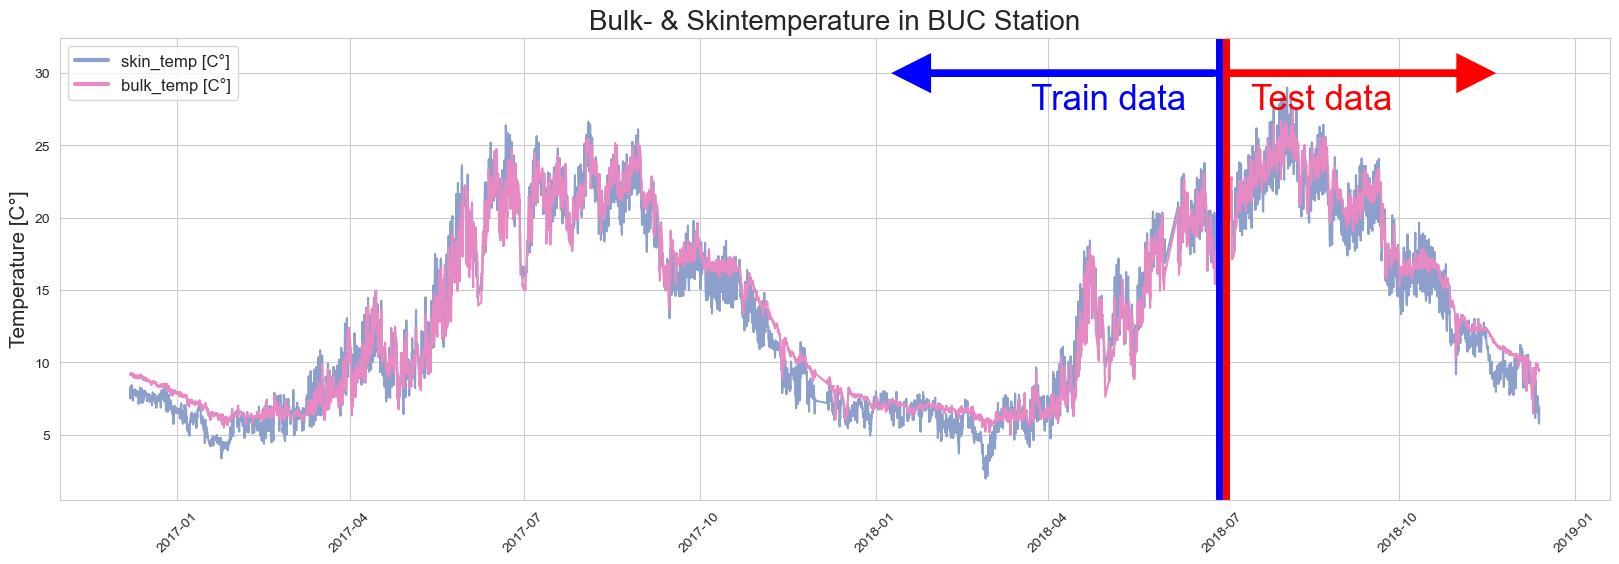

In [3]:
plt.figure(figsize=(20, 6))
plt.plot(BUC_csv["datetime"],BUC_csv["skin_temp"],label="skin_temp [C°]",color=colors[2])
plt.plot(BUC_csv["datetime"],BUC_csv["bulk_temp"],label="bulk_temp [C°]",color=colors[3])

#Vertical Line
plt.axvline(x=pd.Timestamp(split_date)+ pd.DateOffset(2),color="red",linewidth=5)
plt.axvline(x=pd.Timestamp(split_date)- pd.DateOffset(2),color="blue",linewidth=5)

#Arrows
plt.arrow(pd.Timestamp(split_date)+ pd.DateOffset(4),30,120,0,head_width=2, head_length=15, fc='red', ec='red',linewidth=5)
plt.text(pd.Timestamp(split_date)+ pd.DateOffset(15), 27.5, "Test data", fontsize=25,color="red")

plt.arrow(pd.Timestamp(split_date)- pd.DateOffset(4),30,-150,0,head_width=2, head_length=15, fc='blue', ec='blue',linewidth=5)
plt.text(pd.Timestamp(split_date)- pd.DateOffset(100), 27.5, "Train data", fontsize=25,color="blue")
plt.xticks(rotation=45)

#Other things
plt.title("Bulk- & Skintemperature in BUC Station", fontdict={'fontsize': 20})
plt.ylabel("Temperature [C°]", fontdict={'fontsize': 15})
legend=plt.legend(loc="upper left",fontsize="12")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3
plt.plot()

## What is Gradient Boosting Regression?

In [4]:
#CODE:
def apply_table_styles(df):
    return df.style.set_table_styles(
        [
            {
                'selector': 'th',
                'props': [('background-color', 'lightgray')]
            },
            {
                'selector': 'tbody tr:nth-child(even)',
                'props': [('background-color', "lightblue")]
            }
        ]
    )


comparison_dict = {
    'Algorithm': ['Random Forest', 'Gradient Boosting Regression'],
    'Training approach': ['Independent and parallel', 'Sequential and residuals'],
    'Bias-variance tradeoff': ['Higher bias, lower variance', 'Lower bias, higher variance'],
    'Speed': ['Faster for large datasets', 'Slower for large datasets'],
    'Hyperparameters': ['Number of trees, maximum depth', 'Learning rate, number of trees'],
    'Interpretability': ['Lower', 'Higher'],
    'Handling missing values': ['Able to handle missing values', 'Not able to handle missing values'],
    'Robustness to outliers': ['More robust', 'Less robust'],
    'Model performance': ['Stable performance', 'Tendency to overfit']
}

# Convert the dictionary to a pandas DataFrame
comparison_df = pd.DataFrame.from_dict(comparison_dict).T.rename_axis('Algorithm', axis=1).drop(index="Algorithm")
comparison_df.columns = ['Random Forest', 'Gradient Boosting Regression']

# Create a simple dataset
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = np.sin(X).ravel()


# Create Gradient Boosting Regression model
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)

# Train model on data
gbr.fit(X, y)

GradientBoostingRegressor(max_depth=4, random_state=42)

#### What is this algorithm (simple explanation):
The GBR works by combining many decision trees. Each tree tries to fix the mistakes made by the previous trees. The trees are added together, creating an ensemble that makes a prediction.

The hyperparameters of GBR include the number of trees in the ensemble (n_estimators), the learning rate (learning_rate) that controls the contribution of each tree to the ensemble, and the maximum depth of each tree (max_depth), among others.

-> These hyperparameters need to be tuned carefully to obtain the best performance from the model. So we will use the CrossValidationCV module, which is quite good.

An decision tree is visualized below:

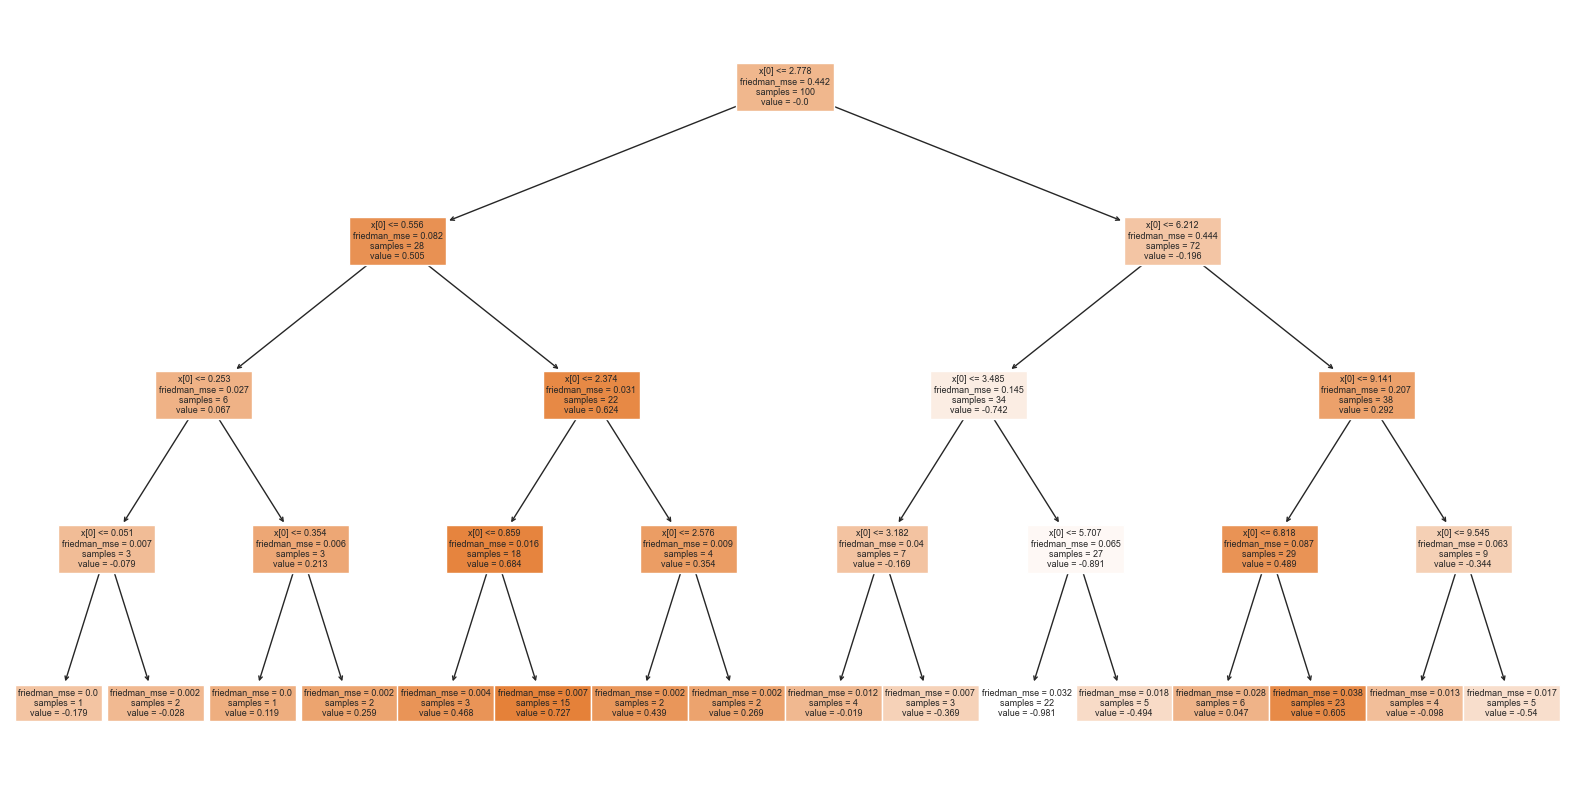

In [5]:
plt.figure(figsize=(20, 10))
plot_tree(gbr.estimators_[0, 0], filled=True)
plt.show()

#### But what is the difference between GBR and RF?

In [6]:
display(apply_table_styles(comparison_df))

,Random Forest,Gradient Boosting Regression
Training approach,Independent and parallel,Sequential and residuals
Bias-variance tradeoff,"Higher bias, lower variance","Lower bias, higher variance"
Speed,Faster for large datasets,Slower for large datasets
Hyperparameters,"Number of trees, maximum depth","Learning rate, number of trees"
Interpretability,Lower,Higher
Handling missing values,Able to handle missing values,Not able to handle missing values
Robustness to outliers,More robust,Less robust
Model performance,Stable performance,Tendency to overfit


## Coding the GBR Model with CrossValidation and Hyperparameter tuning: (Attempt 2: Skin Effect)

In [7]:
test_set=test_set_raw.copy()
train_set=train_set_raw.copy()

#Grid search is quite useful here:
#define the parameters to choose from
param_grid = {
    "max_depth": [5,7,9],
    "learning_rate": [0.01,0.1],
}
#define the scorer, in this case we can use the mean squared error:
mse_scorer = make_scorer(r2_score)

#initialize the model:
gbr = GradientBoostingRegressor()

#make the GridSearch:

grid_search2 = HalvingGridSearchCV(
    estimator=gbr, #implement the GradienBoostingRegressor
    param_grid=param_grid, #the defined parameters (see above)
    scoring=mse_scorer, #the lower the score (in this case the mse), the better the model
    cv=cv_score, #5-fold Cross Validation -> quite normal here!
    n_jobs=-1, #use 1 core of the CPU
    verbose=10,#print progress messages
    factor=2,
    resource="n_estimators",
    max_resources=2500
)
#fit it to the train-set: if False, the fitted model will be loaded from disk:
if fit_attempt2 == True:
    grid_search2.fit(train_set.drop(columns=["skin_effect","datetime","bulk_temp"]),train_set["skin_effect"])
    pickle.dump(grid_search2, open(filename_attempt2, 'wb'))

else:
    grid_search2 = pickle.load(open(filename_attempt2, 'rb'))


#get the best hyperparameters and the mse:
best_params = grid_search2.best_params_
best_score = grid_search2.best_score_
print("----------------------------")
print("Best Parameters:",best_params)
print("Best Score (r2):",best_score)

----------------------------
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 2500}
Best Score (r2): 0.5101089389193137


In [8]:
test_set=test_set.copy()
test_set["skin_effect_predicted"]= grid_search2.predict(test_set.drop(columns=["skin_effect","datetime","bulk_temp"]))

mse_2=mean_squared_error(test_set["skin_effect_predicted"],test_set["skin_effect"])
r2_2=r2_score(test_set["skin_effect"],test_set["skin_effect_predicted"])
n = len(test_set["skin_effect"])  # number of observations
p = 7  # number of predictors (features)
r2_adjusted = 1 - (1 - r2_2) * (n - 1) / (n - p - 1)

----------------------------------
Mean Squared Error: 0.863
R-squared score: 0.29
Adjusted R-squared score: 0.288
    feature name  importance
1       air_temp    0.556924
0      skin_temp    0.280886
4        solar_W    0.068877
5   rel_humidity    0.043627
3      windspeed    0.038571
6   air_pressure    0.008450
7      day_night    0.002665
2  precipitation    0.000000


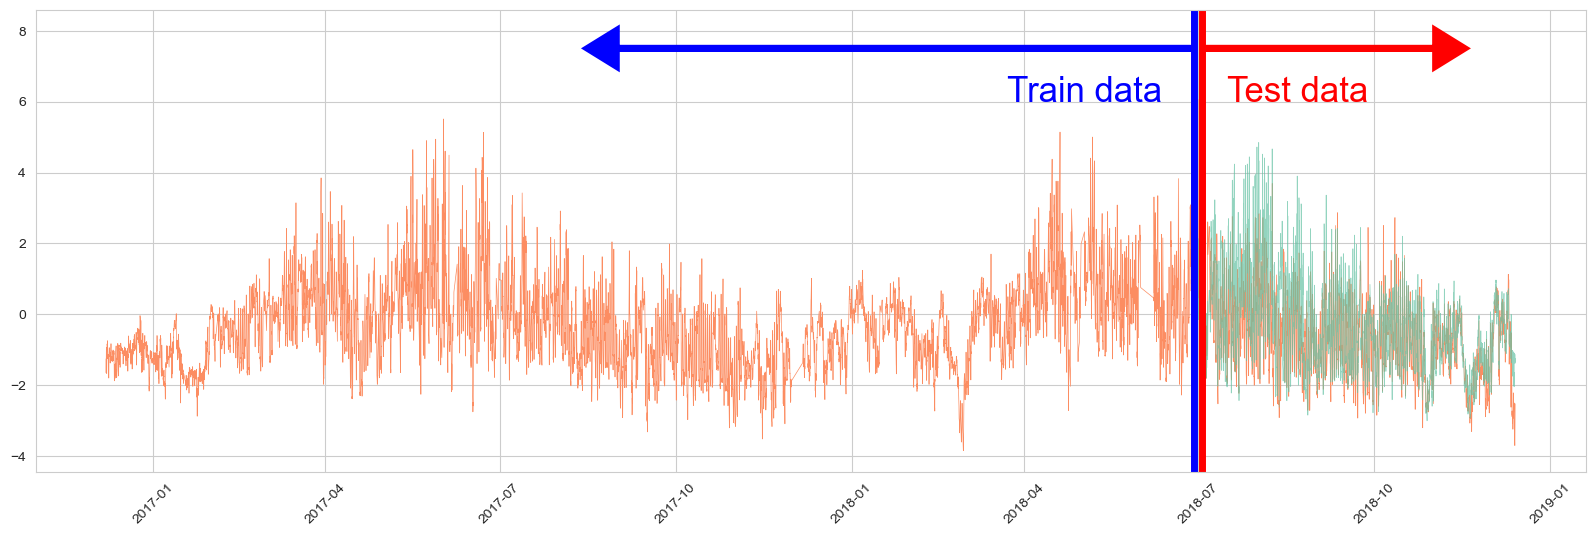

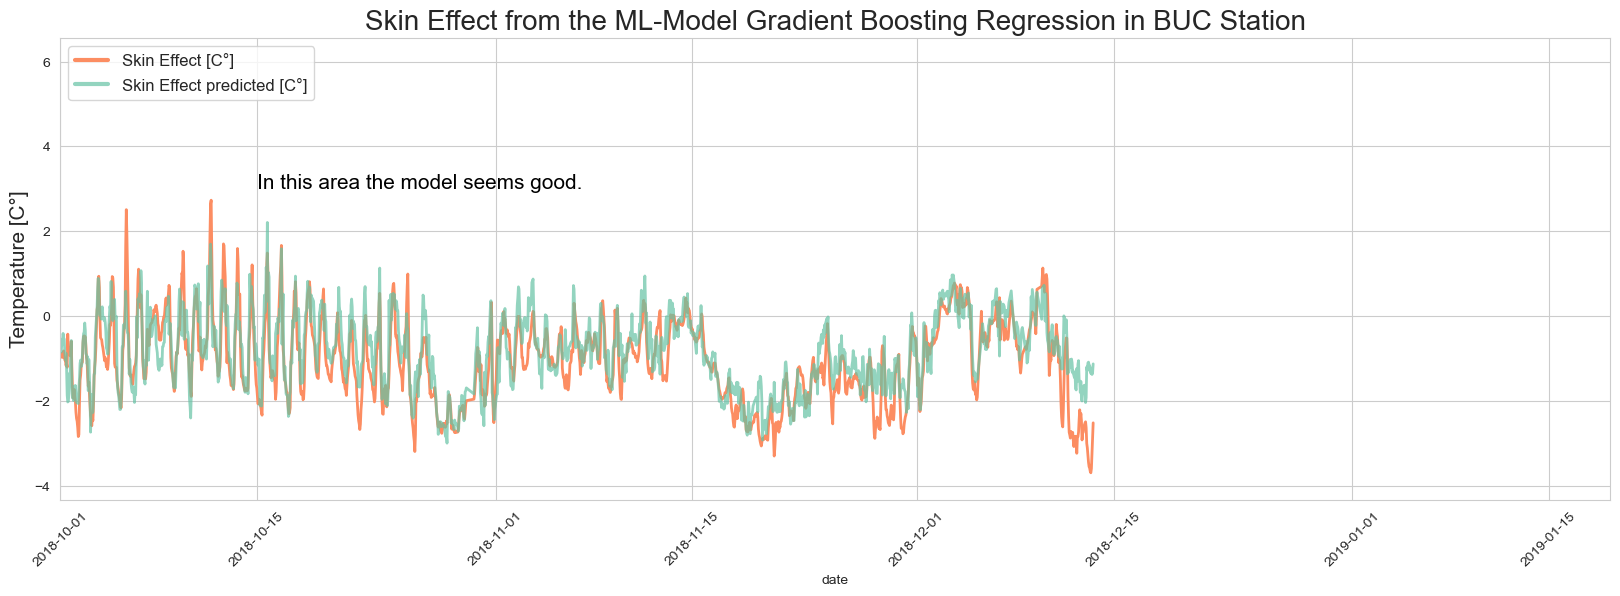

In [9]:
plt.figure(figsize=(20, 6))
plt.plot(BUC_csv["datetime"],BUC_csv["skin_effect"],label="Skin Effect [C°]", color=colors[1],alpha=1,linewidth =0.5)
plt.plot(test_set["datetime"],test_set["skin_effect_predicted"],label="Skin Effect predicted [C°]", color=colors[0],alpha=0.7,linewidth =0.5)
plt.xticks(rotation=45)

#Vertical Line
plt.axvline(x=pd.Timestamp(split_date)+ pd.DateOffset(2),color="red",linewidth=5)
plt.axvline(x=pd.Timestamp(split_date)- pd.DateOffset(2),color="blue",linewidth=5)

#Arrows
plt.arrow(pd.Timestamp(split_date)+ pd.DateOffset(4),7.5,120,0,head_width=1, head_length=15, fc='red', ec='red',linewidth=5)
plt.text(pd.Timestamp(split_date)+ pd.DateOffset(15), 6, "Test data", fontsize=25,color="red")

plt.arrow(pd.Timestamp(split_date)- pd.DateOffset(4),7.5,-300,0,head_width=1, head_length=15, fc='blue', ec='blue',linewidth=5)
plt.text(pd.Timestamp(split_date)- pd.DateOffset(100), 6, "Train data", fontsize=25,color="blue")


#SUBSET of Timeseries:
plt.figure(figsize=(20, 6))
plt.plot(BUC_csv["datetime"],BUC_csv["skin_effect"],label="Skin Effect [C°]", color=colors[1],alpha=1,linewidth =2)
plt.plot(test_set["datetime"],test_set["skin_effect_predicted"],label="Skin Effect predicted [C°]", color=colors[0],alpha=0.7,linewidth =2)

plt.text(pd.Timestamp("2018-10-15"), 3, f"In this area the model seems good.", fontsize=15,color="black")
#Other things
plt.title("Subset of predicted skin-effect with the GBR in BUC Station", fontdict={'fontsize': 20})
plt.xlabel("date")
plt.xticks(rotation=45)
plt.xlim(pd.Timestamp("2018-10"))
plt.ylabel("Temperature [C°]")
legend=plt.legend(fontsize="12",loc="upper left")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3


#Other things
plt.title("Skin Effect from the ML-Model Gradient Boosting Regression in BUC Station", fontdict={'fontsize': 20})
plt.ylabel("Temperature [C°]", fontdict={'fontsize': 15})
legend=plt.legend(loc="upper left",fontsize="12")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3
print(f"\033[94m----------------------------------\033[0m")
print(f"\033[94mMean Squared Error: {round(mse_2,3)}\nR-squared score: {round(r2_2,3)}\nAdjusted R-squared score: {round(r2_adjusted,3)}\033[0m")


#best estimator:
best_estimator = grid_search2.best_estimator_
features = train_set.drop(columns=["bulk_temp","datetime"])
importances = best_estimator.feature_importances_
feature_importances2=pd.DataFrame({"feature name": train_set.drop(columns=["bulk_temp","datetime","skin_effect"]).columns,"importance": best_estimator.feature_importances_})
print(feature_importances2.sort_values("importance",ascending=False))


## Coding a RF Model with CrossValidation and Hyperparameter tuning: (Attempt 3: Skin Effect)


What is a Random Forest Model?

-> A Random Forest Model is a ML-Model that combines multiple Decision Trees to Classify or Predict from multivariate Data. This model tends to be more robust as the GBR (more details see below).

In [10]:
display(apply_table_styles(comparison_df))

,Random Forest,Gradient Boosting Regression
Training approach,Independent and parallel,Sequential and residuals
Bias-variance tradeoff,"Higher bias, lower variance","Lower bias, higher variance"
Speed,Faster for large datasets,Slower for large datasets
Hyperparameters,"Number of trees, maximum depth","Learning rate, number of trees"
Interpretability,Lower,Higher
Handling missing values,Able to handle missing values,Not able to handle missing values
Robustness to outliers,More robust,Less robust
Model performance,Stable performance,Tendency to overfit


In [11]:
test_set=test_set_raw.copy()
train_set=train_set_raw.copy()
#Grid search is quite useful here:
#define the parameters to choose from
param_grid = {
    "max_depth": [5,7,9],
    "learning_rate": [0.01,0.1],
}
#define the scorer, in this case we can use the mean squared error:
mse_scorer = make_scorer(mean_squared_error,greater_is_better=False)

#initialize the model:
gbr = GradientBoostingRegressor()

#make the GridSearch:

grid_search3 = HalvingGridSearchCV(
    estimator=gbr, #implement the GradienBoostingRegressor
    param_grid=param_grid, #the defined parameters (see above)
    scoring=mse_scorer, #the lower the score (in this case the mse), the better the model
    cv=cv_score, #5-fold Cross Validation -> quite normal here!
    n_jobs=-1, #use 1 core of the CPU
    verbose=10,#print progress messages
    factor=2,
    resource="n_estimators",
    max_resources=500
)
#fit it to the train-set: if False, the fitted model will be loaded from disk:
if fit_attempt3 == True:
    grid_search3.fit(train_set.drop(columns=["bulk_temp","datetime","skin_effect"]),train_set["bulk_temp"])
    pickle.dump(grid_search3, open(filename_attempt3, 'wb'))

else:
    grid_search3 = pickle.load(open(filename_attempt3, 'rb'))


#get the best hyperparameters and the mse:
best_params = grid_search3.best_params_
best_score = grid_search3.best_score_
print("----------------------------")
print("Best Parameters:",best_params)
print("Best Score (MSE):",best_score)


----------------------------
Best Parameters: {'criterion': 'squared_error', 'max_depth': 12, 'n_estimators': 16}
Best Score (MSE): 0.34764312458991203


In [12]:
#create Lag in the data
test_set=test_set_raw.copy()
train_set=train_set_raw.copy()

In [13]:
#Grid search is quite useful here:
#define the parameters to choose from
param_grid = {
    "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    "max_depth": [3,7,9,12],
    #"min_samples_split": [2]
}
#define the scorer
#scorer = make_scorer(r2_score)
scorer = make_scorer(mean_absolute_error)

#initialize the model:
rfr = RandomForestRegressor()

#make the GridSearch:

grid_search3 = HalvingGridSearchCV(
    estimator=rfr, #implement the GradienBoostingRegressor
    param_grid=param_grid, #the defined parameters (see above)
    scoring=mse_scorer,
    cv=cv_score, #5-fold Cross Validation -> quite normal here!
    n_jobs=-1, #use 1 core of the CPU
    verbose=10,#print progress messages
    factor=2,
    resource="n_estimators",
    max_resources=20
)
#fit it to the train-set: if False, the fitted model will be loaded from disk:
if fit_attempt3 == True:
    grid_search3.fit(train_set.drop(columns=["skin_effect","datetime","bulk_temp"]),train_set["skin_effect"])
    pickle.dump(grid_search3, open(filename_attempt3, 'wb'))

else:
    grid_search3 = pickle.load(open(filename_attempt3, 'rb'))


#get the best hyperparameters and the mse:
best_params = grid_search3.best_params_
best_score = grid_search3.best_score_
print("----------------------------")
print("Best Parameters:",best_params)
print("Best Score (mae):",best_score)

----------------------------
Best Parameters: {'criterion': 'squared_error', 'max_depth': 12, 'n_estimators': 16}
Best Score (mae): 0.34764312458991203


In [14]:
test_set=test_set.copy()
test_set["skin_effect_predicted"]= grid_search3.predict(test_set.drop(columns=["skin_effect","datetime","bulk_temp"]))

mse_3=mean_squared_error(test_set["skin_effect_predicted"],test_set["skin_effect"])
r2_3=r2_score(test_set["skin_effect"],test_set["skin_effect_predicted"])
n = len(test_set["skin_effect"])  # number of observations
p = 5  # number of predictors (features)
r2_adjusted = 1 - (1 - r2_3) * (n - 1) / (n - p - 1)

----------------------------------
Mean Squared Error: 0.637
R-squared score: 0.475
Adjusted R-squared score: 0.475

Feature Importance:
    feature name  importance
0       air_temp    0.565973
1      skin_temp    0.254603
2   rel_humidity    0.064971
3        solar_W    0.061772
4      windspeed    0.044158
5   air_pressure    0.006663
6      day_night    0.001860
7  precipitation    0.000000
----------------------------------


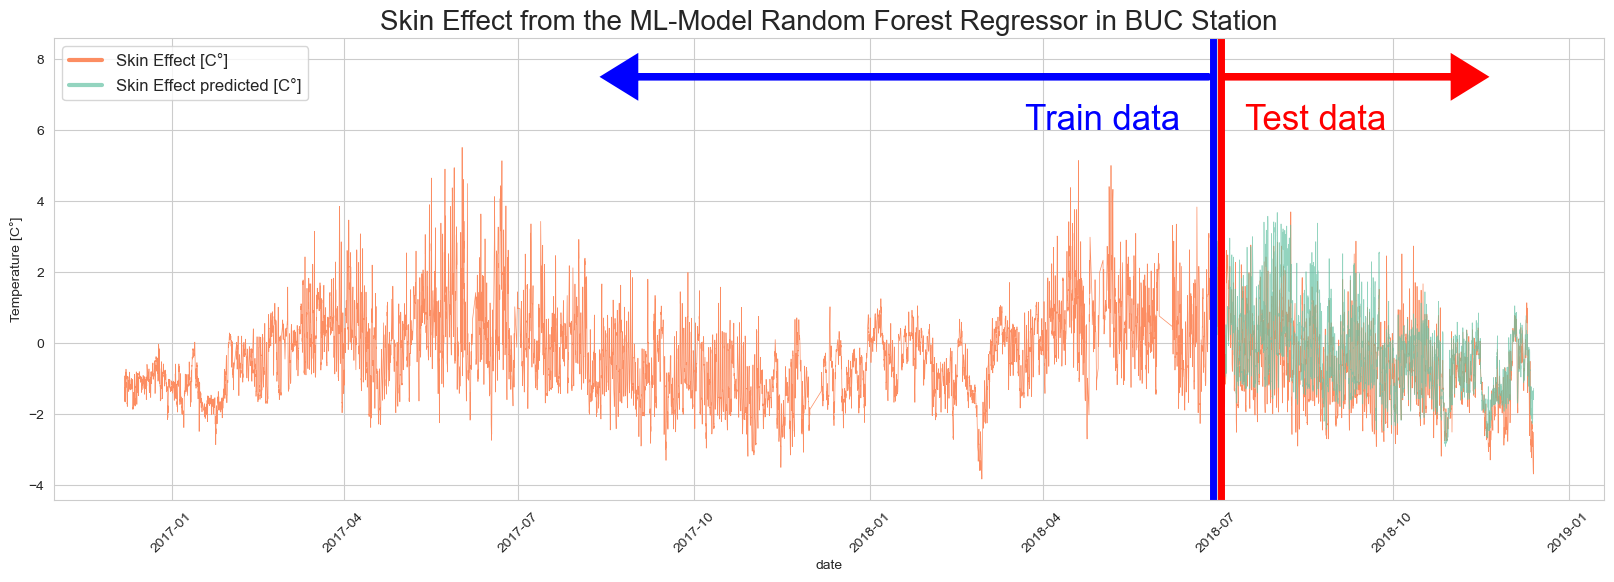

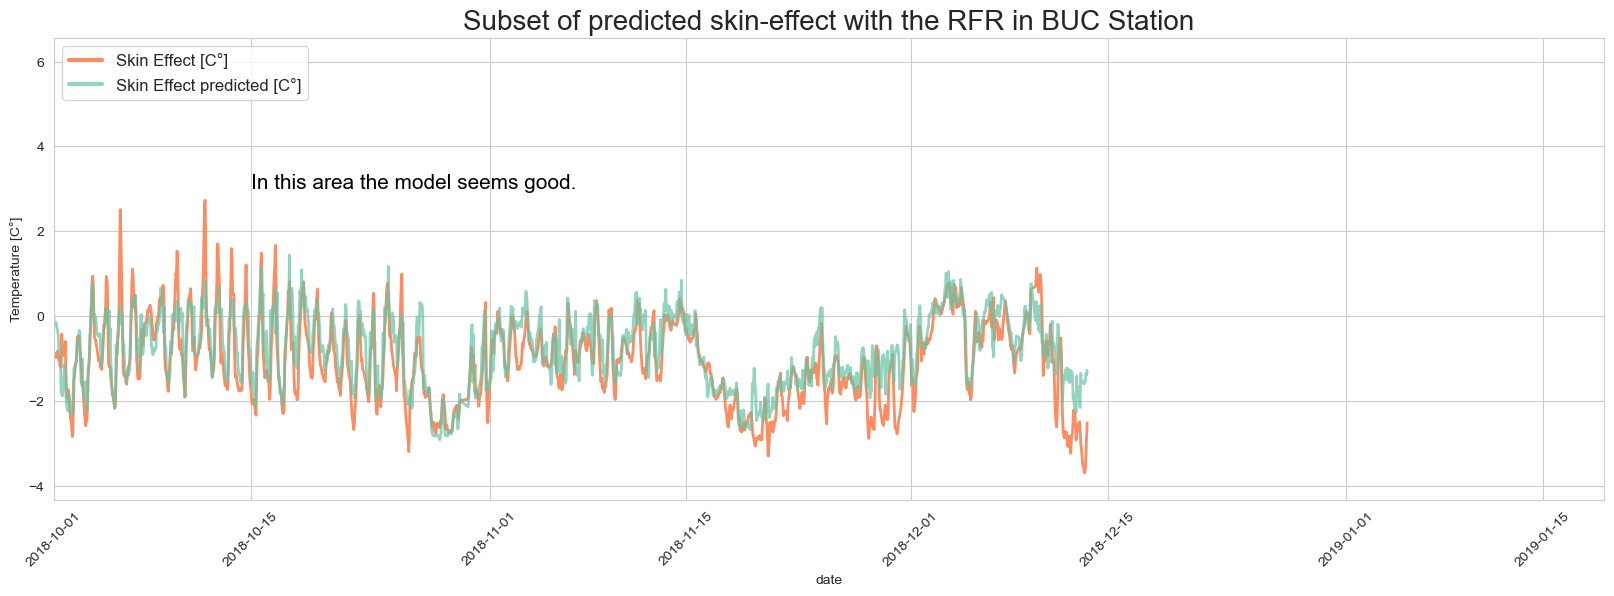

In [15]:
plt.figure(figsize=(20, 6))
plt.plot(BUC_csv["datetime"],BUC_csv["skin_effect"],label="Skin Effect [C°]", color=colors[1],alpha=1,linewidth =0.5)
plt.plot(test_set["datetime"],test_set["skin_effect_predicted"],label="Skin Effect predicted [C°]", color=colors[0],alpha=0.7,linewidth =0.5)
plt.xticks(rotation=45)

#Vertical Line
plt.axvline(x=pd.Timestamp(split_date)+ pd.DateOffset(2),color="red",linewidth=5)
plt.axvline(x=pd.Timestamp(split_date)- pd.DateOffset(2),color="blue",linewidth=5)

#Arrows
plt.arrow(pd.Timestamp(split_date)+ pd.DateOffset(4),7.5,120,0,head_width=1, head_length=15, fc='red', ec='red',linewidth=5)
plt.text(pd.Timestamp(split_date)+ pd.DateOffset(15), 6, "Test data", fontsize=25,color="red")

plt.arrow(pd.Timestamp(split_date)- pd.DateOffset(4),7.5,-300,0,head_width=1, head_length=15, fc='blue', ec='blue',linewidth=5)
plt.text(pd.Timestamp(split_date)- pd.DateOffset(100), 6, "Train data", fontsize=25,color="blue")

#Other things
plt.title("Skin Effect from the ML-Model Random Forest Regressor in BUC Station", fontdict={'fontsize': 20})
plt.xlabel("date")
plt.ylabel("Temperature [C°]")
legend=plt.legend(fontsize="12",loc="upper left")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3


#SUBSET of Timeseries:
plt.figure(figsize=(20, 6))
plt.plot(BUC_csv["datetime"],BUC_csv["skin_effect"],label="Skin Effect [C°]", color=colors[1],alpha=1,linewidth =2)
plt.plot(test_set["datetime"],test_set["skin_effect_predicted"],label="Skin Effect predicted [C°]", color=colors[0],alpha=0.7,linewidth =2)

plt.text(pd.Timestamp("2018-10-15"), 3, f"In this area the model seems good.", fontsize=15,color="black")
#Other things
plt.title("Subset of predicted skin-effect with the RFR in BUC Station", fontdict={'fontsize': 20})
plt.xlabel("date")
plt.xticks(rotation=45)
plt.xlim(pd.Timestamp("2018-10"))
plt.ylabel("Temperature [C°]")
legend=plt.legend(fontsize="12",loc="upper left")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3


print(f"\033[94m----------------------------------\033[0m")
print(f"\033[94mMean Squared Error: {round(mse_3,3)}\nR-squared score: {round(r2_3,3)}\nAdjusted R-squared score: {round(r2_adjusted,3)}\033[0m")


#best estimator:
best_estimator= grid_search3.best_estimator_
feature_importances3=pd.DataFrame({"feature name": train_set.drop(columns=["skin_effect","datetime","bulk_temp"]).columns,"importance": best_estimator.feature_importances_})
print("")
print(f"\033[94mFeature Importance:\033[0m")
print(f"\033[94m{feature_importances3.sort_values('importance',ascending=False).reset_index(drop=True)}\033[0m")
print(f"\033[94m----------------------------------\033[0m")

## Coding a XGBOOST Model with CrossValidation and Hyperparameter tuning: (Attempt 4: Skin Effect)


In [16]:
#create Lag in the data
test_set=test_set_raw.copy()
train_set=train_set_raw.copy()
if lag_true == True:
    for i in lags:
        string_air="air_temp_lag"+str(i)
        string_wind="windspeed_lag"+str(i)
        string_solar="solar_lag"+str(i)

        test_set[string_air]= test_set['air_temp'].shift(i)
        train_set[string_air]= train_set['air_temp'].shift(i)

        test_set[string_wind]= test_set['windspeed'].shift(i)
        train_set[string_wind]= train_set['windspeed'].shift(i)

        test_set[string_solar]= test_set['solar_W'].shift(i)
        train_set[string_solar]= train_set['solar_W'].shift(i)

    test_set=test_set.dropna()


C:\Users\claud\AppData\Local\Temp\ipykernel_8984\516978654.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_set[string_wind]= test_set['windspeed'].shift(i)
C:\Users\claud\AppData\Local\Temp\ipykernel_8984\516978654.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set[string_wind]= train_set['windspeed'].shift(i)
C:\Users\claud\AppData\Local\Temp\ipykernel_8984\516978654.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

In [ ]:
#Grid search is quite useful here:
#define the parameters to choose from
param_grid = {
    "tree_method":["auto","exact"]
    #"scale_pos_weight":[sum(negative instances) / sum(positive instances)]
    
}
#define the scorer, in this case we can use the mean squared error:
scorer=make_scorer(r2_score)
#initialize the model:
rfr = XGBRegressor()

#make the GridSearch:

grid_search4 = GridSearchCV(
    estimator=rfr, #implement the GradienBoostingRegressor
    param_grid=param_grid, #the defined parameters (see above)
    cv=cv_score, #5-fold Cross Validation -> quite normal here!
    n_jobs=1, #use 1 core of the CPU
    verbose=10,#print progress messages
)
#fit it to the train-set: if False, the fitted model will be loaded from disk:
if fit_attempt4 == True:
    grid_search4.fit(train_set.drop(columns=["skin_effect","datetime","bulk_temp"]),train_set["skin_effect"])
    pickle.dump(grid_search4, open(filename_attempt4, 'wb'))

else:
    grid_search4 = pickle.load(open(filename_attempt4, 'rb'))


#get the best hyperparameters and the mse:
best_params = grid_search4.best_params_
best_score = grid_search4.best_score_
print("----------------------------")
print("Best Parameters:",best_params)
print("Best Score:",best_score)

test_set=test_set.copy()
test_set["skin_effect_predicted"]= grid_search4.predict(test_set.drop(columns=["skin_effect","bulk_temp","datetime"]))

mse_4=mean_squared_error(test_set["skin_effect_predicted"],test_set["skin_effect"])
r2_4=r2_score(test_set["skin_effect"],test_set["skin_effect_predicted"])
n = len(test_set["skin_effect"])  # number of observations
p = 5  # number of predictors (features)
r2_adjusted = 1 - (1 - r2_4) * (n - 1) / (n - p - 1)


plt.figure(figsize=(20, 6))
plt.plot(BUC_csv["datetime"],BUC_csv["skin_effect"],label="Skin Effect [C°]", color=colors[1],alpha=1,linewidth =0.8)
plt.plot(test_set["datetime"],test_set["skin_effect_predicted"],label="Skin Effect predicted [C°]", color=colors[0],alpha=0.7,linewidth =0.8)
plt.xticks(rotation=45)

#Vertical Line
plt.axvline(x=pd.Timestamp(split_date)+ pd.DateOffset(2),color="red",linewidth=5)
plt.axvline(x=pd.Timestamp(split_date)- pd.DateOffset(2),color="blue",linewidth=5)

#Arrows
plt.arrow(pd.Timestamp(split_date)+ pd.DateOffset(4),7.5,120,0,head_width=1, head_length=15, fc='red', ec='red',linewidth=5)
plt.text(pd.Timestamp(split_date)+ pd.DateOffset(15), 6, "Test data", fontsize=25,color="red")

plt.arrow(pd.Timestamp(split_date)- pd.DateOffset(4),7.5,-300,0,head_width=1, head_length=15, fc='blue', ec='blue',linewidth=5)
plt.text(pd.Timestamp(split_date)- pd.DateOffset(100), 6, "Train data", fontsize=25,color="blue")

#Other things
plt.title("Skin Effect from the ML-Model Support Vector Regressor in BUC Station")
plt.xlabel("date")
plt.ylabel("Temperature [C°]")
legend=plt.legend(fontsize="12",loc="upper left")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3

print(f"\033[94m----------------------------------\033[0m")
print(f"\033[94mMean Squared Error: {round(mse_4,3)}\nR-squared score: {round(r2_4,3)}\nAdjusted R-squared score: {round(r2_adjusted,3)}\033[0m")


#best estimator:
best_estimator= grid_search4.best_estimator_
importance_scores = best_estimator.feature_importances_


feature_importances4=pd.DataFrame({"feature name": train_set.drop(columns=["skin_effect","bulk_temp","datetime"]).columns,"importance": importance_scores})
print("")
print(f"\033[94mFeature Importance:\033[0m")
print(f"\033[94m{feature_importances4.sort_values('importance',ascending=False).reset_index(drop=True)}\033[0m")
print(f"\033[94m----------------------------------\033[0m")


#SUBSET of Timeseries:
plt.figure(figsize=(20, 6))
plt.plot(BUC_csv["datetime"],BUC_csv["skin_effect"],label="Skin Effect [C°]", color=colors[1],alpha=1,linewidth =2)
plt.plot(test_set["datetime"],test_set["skin_effect_predicted"],label="Skin Effect predicted [C°]", color=colors[0],alpha=0.7,linewidth =2)

plt.text(pd.Timestamp("2018-10-15"), 3, f"In this area the model seems good.", fontsize=15,color="black")
#Other things
plt.title("Subset of predicted skin-effect with the RFR in BUC Station", fontdict={'fontsize': 20})
plt.xlabel("date")
plt.xticks(rotation=45)
plt.xlim(pd.Timestamp(split_date))
plt.ylabel("Temperature [C°]")
legend=plt.legend(fontsize="12",loc="upper left")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START tree_method=auto............................................


# LightGBM from Microsoft (CV / hyperparameter tuning)

LightGBM is another gradient boosting framework developed by Microsoft. It is known for its efficiency and speed, particularly on large-scale datasets. LightGBM uses a different tree growth strategy called "leaf-wise" instead of the level-wise strategy used by XGBoost, which can lead to faster training times.

In [ ]:
#create Lag in the data
test_set=test_set_raw.copy()
train_set=train_set_raw.copy()
if lag_true == True:
    for i in lags:
        string_air="air_temp_lag"+str(i)
        string_wind="windspeed_lag"+str(i)
        string_solar="solar_lag"+str(i)

        test_set[string_air]= test_set['air_temp'].shift(i)
        train_set[string_air]= train_set['air_temp'].shift(i)

        test_set[string_wind]= test_set['windspeed'].shift(i)
        train_set[string_wind]= train_set['windspeed'].shift(i)

        test_set[string_solar]= test_set['solar_W'].shift(i)
        train_set[string_solar]= train_set['solar_W'].shift(i)

    test_set=test_set.dropna()


In [ ]:
#Grid search is quite useful here:
#define the parameters to choose from
param_grid = {
    'learning_rate': [0.1],
    'max_depth': [5, 7, 9],
    'n_estimators': [1000],
    'num_leaves': [10, 20, 31]
}
#define the scorer, in this case we can use the mean squared error:
scorer = {
    'mse': make_scorer(mean_squared_error, greater_is_better=False),
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}#initialize the model:
rfr = lgb.LGBMRegressor()

#make the GridSearch:

grid_search5 = GridSearchCV(
    estimator=rfr, #implement the GradienBoostingRegressor
    param_grid=param_grid, #the defined parameters (see above)
    scoring=scorer,
    cv=cv_score, #5-fold Cross Validation -> quite normal here!
    n_jobs=-1, #use 1 core of the CPU,
    refit='mse',
    verbose=10,#print progress messages
)
#fit it to the train-set: if False, the fitted model will be loaded from disk:
if fit_attempt5 == True:
    grid_search5.fit(train_set.drop(columns=["skin_effect","datetime","bulk_temp"]),train_set["skin_effect"])
    pickle.dump(grid_search5, open(filename_attempt5, 'wb'))

else:
    grid_search5 = pickle.load(open(filename_attempt5, 'rb'))


#get the best hyperparameters and the mse:
best_params = grid_search5.best_params_
best_score = grid_search5.best_score_
print("----------------------------")
print("Best Parameters:",best_params)
print("Best Score:",best_score)


test_set=test_set.copy()
test_set["skin_effect_predicted"]= grid_search5.predict(test_set.drop(columns=["skin_effect","bulk_temp","datetime"]))


mse_5=mean_squared_error(test_set["skin_effect_predicted"],test_set["skin_effect"])
r2_5=r2_score(test_set["skin_effect"],test_set["skin_effect_predicted"])
n = len(test_set["skin_effect"])  # number of observations
p = 5  # number of predictors (features)
r2_adjusted = 1 - (1 - r2_5) * (n - 1) / (n - p - 1)


plt.figure(figsize=(20, 6))
plt.plot(BUC_csv["datetime"],BUC_csv["skin_effect"],label="Skin Effect [C°]", color=colors[1],alpha=1,linewidth =0.8)
plt.plot(test_set["datetime"],test_set["skin_effect_predicted"],label="Skin Effect predicted [C°]", color=colors[0],alpha=0.7,linewidth =0.8)
plt.xticks(rotation=45)

#Vertical Line
plt.axvline(x=pd.Timestamp(split_date)+ pd.DateOffset(2),color="red",linewidth=5)
plt.axvline(x=pd.Timestamp(split_date)- pd.DateOffset(2),color="blue",linewidth=5)

#Arrows
plt.arrow(pd.Timestamp(split_date)+ pd.DateOffset(4),7.5,120,0,head_width=1, head_length=15, fc='red', ec='red',linewidth=5)
plt.text(pd.Timestamp(split_date)+ pd.DateOffset(15), 6, "Test data", fontsize=25,color="red")

plt.arrow(pd.Timestamp(split_date)- pd.DateOffset(4),7.5,-300,0,head_width=1, head_length=15, fc='blue', ec='blue',linewidth=5)
plt.text(pd.Timestamp(split_date)- pd.DateOffset(100), 6, "Train data", fontsize=25,color="blue")

#Other things
plt.title("Skin Effect from the ML-Model Support Vector Regressor in BUC Station")
plt.xlabel("date")
plt.ylabel("Temperature [C°]")
legend=plt.legend(fontsize="12",loc="upper left")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3

print(f"\033[94m----------------------------------\033[0m")
print(f"\033[94mMean Squared Error: {round(mse_5,3)}\nR-squared score: {round(r2_5,3)}\nAdjusted R-squared score: {round(r2_adjusted,3)}\033[0m")


#best estimator:
best_estimator= grid_search5.best_estimator_
importance_scores = best_estimator.feature_importances_


feature_importances5=pd.DataFrame({"feature name": train_set.drop(columns=["skin_effect","bulk_temp","datetime"]).columns,"importance": importance_scores})
print("")
print(f"\033[94mFeature Importance:\033[0m")
print(f"\033[94m----------------------------------\033[0m")

display(feature_importances5.sort_values('importance',ascending=False).reset_index(drop=True))


#SUBSET of Timeseries:
plt.figure(figsize=(20, 6))
plt.plot(BUC_csv["datetime"],BUC_csv["skin_effect"],label="Skin Effect [C°]", color=colors[1],alpha=1,linewidth =2)
plt.plot(test_set["datetime"],test_set["skin_effect_predicted"],label="Skin Effect predicted [C°]", color=colors[0],alpha=0.7,linewidth =2)

plt.text(pd.Timestamp("2018-10-15"), 3, f"In this area the model seems good.", fontsize=15,color="black")
plt.title("Subset of predicted skin-effect with the RFR in BUC Station", fontdict={'fontsize': 20})
plt.xlabel("date")
plt.xticks(rotation=45)
plt.xlim(pd.Timestamp(split_date))
plt.ylabel("Temperature [C°]")
legend=plt.legend(fontsize="12",loc="upper left")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3

# CatBoost Attempt

In [ ]:
#create Lag in the data
test_set=test_set_raw.copy()
train_set=train_set_raw.copy()
if lag_true == True:
    for i in lags:
        string_air="air_temp_lag"+str(i)
        string_wind="windspeed_lag"+str(i)
        string_solar="solar_lag"+str(i)

        test_set[string_air]= test_set['air_temp'].shift(i)
        train_set[string_air]= train_set['air_temp'].shift(i)

        test_set[string_wind]= test_set['windspeed'].shift(i)
        train_set[string_wind]= train_set['windspeed'].shift(i)

        test_set[string_solar]= test_set['solar_W'].shift(i)
        train_set[string_solar]= train_set['solar_W'].shift(i)

    test_set=test_set.dropna()


In [ ]:
#Grid search is quite useful here:
#define the parameters to choose from
param_grid = {
    'learning_rate': [0.1],
    'max_depth': [5, 7, 9],
    'n_estimators': [1000],
    'num_leaves': [10, 20, 31]
}
#define the scorer, in this case we can use the mean squared error:
scorer = {
    'mse': make_scorer(mean_squared_error, greater_is_better=False),
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}#initialize the model:
rfr = cb.CatBoostRegressor()

#make the GridSearch:

grid_search6 = GridSearchCV(
    estimator=rfr, #implement the GradienBoostingRegressor
    param_grid=param_grid, #the defined parameters (see above)
    scoring=scorer,
    cv=cv_score, #5-fold Cross Validation -> quite normal here!
    n_jobs=-1, #use 1 core of the CPU,
    refit='mse',
    verbose=10,#print progress messages
)
#fit it to the train-set: if False, the fitted model will be loaded from disk:
if fit_attempt6 == True:
    grid_search6.fit(train_set.drop(columns=["skin_effect","datetime","bulk_temp"]),train_set["skin_effect"])
    pickle.dump(grid_search6, open(filename_attempt6, 'wb'))

else:
    grid_search6 = pickle.load(open(filename_attempt6, 'rb'))


#get the best hyperparameters and the mse:
best_params = grid_search6.best_params_
best_score = grid_search6.best_score_
print("----------------------------")
print("Best Parameters:",best_params)
print("Best Score:",best_score)


test_set=test_set.copy()
test_set["skin_effect_predicted"]= grid_search6.predict(test_set.drop(columns=["skin_effect","bulk_temp","datetime"]))


mse_6=mean_squared_error(test_set["skin_effect_predicted"],test_set["skin_effect"])
r2_6=r2_score(test_set["skin_effect"],test_set["skin_effect_predicted"])
n = len(test_set["skin_effect"])  # number of observations
p = 5  # number of predictors (features)
r2_adjusted = 1 - (1 - r2_6) * (n - 1) / (n - p - 1)


plt.figure(figsize=(20, 6))
plt.plot(BUC_csv["datetime"],BUC_csv["skin_effect"],label="Skin Effect [C°]", color=colors[1],alpha=1,linewidth =0.8)
plt.plot(test_set["datetime"],test_set["skin_effect_predicted"],label="Skin Effect predicted [C°]", color=colors[0],alpha=0.7,linewidth =0.8)
plt.xticks(rotation=45)

#Vertical Line
plt.axvline(x=pd.Timestamp(split_date)+ pd.DateOffset(2),color="red",linewidth=5)
plt.axvline(x=pd.Timestamp(split_date)- pd.DateOffset(2),color="blue",linewidth=5)

#Arrows
plt.arrow(pd.Timestamp(split_date)+ pd.DateOffset(4),7.5,120,0,head_width=1, head_length=15, fc='red', ec='red',linewidth=5)
plt.text(pd.Timestamp(split_date)+ pd.DateOffset(15), 6, "Test data", fontsize=25,color="red")

plt.arrow(pd.Timestamp(split_date)- pd.DateOffset(4),7.5,-300,0,head_width=1, head_length=15, fc='blue', ec='blue',linewidth=5)
plt.text(pd.Timestamp(split_date)- pd.DateOffset(100), 6, "Train data", fontsize=25,color="blue")

#Other things
plt.title("Skin Effect from the ML-Model Support Vector Regressor in BUC Station")
plt.xlabel("date")
plt.ylabel("Temperature [C°]")
legend=plt.legend(fontsize="12",loc="upper left")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3

print(f"\033[94m----------------------------------\033[0m")
print(f"\033[94mMean Squared Error: {round(mse_6,3)}\nR-squared score: {round(r2_6,3)}\nAdjusted R-squared score: {round(r2_adjusted,3)}\033[0m")


#best estimator:
best_estimator= grid_search6.best_estimator_
importance_scores = best_estimator.feature_importances_


feature_importances6=pd.DataFrame({"feature name": train_set.drop(columns=["skin_effect","bulk_temp","datetime"]).columns,"importance": importance_scores})
print("")
print(f"\033[94mFeature Importance:\033[0m")
print(f"\033[94m----------------------------------\033[0m")

display(feature_importances6.sort_values('importance',ascending=False).reset_index(drop=True))


#SUBSET of Timeseries:
plt.figure(figsize=(20, 6))
plt.plot(BUC_csv["datetime"],BUC_csv["skin_effect"],label="Skin Effect [C°]", color=colors[1],alpha=1,linewidth =2)
plt.plot(test_set["datetime"],test_set["skin_effect_predicted"],label="Skin Effect predicted [C°]", color=colors[0],alpha=0.7,linewidth =2)

plt.text(pd.Timestamp("2018-10-15"), 3, f"In this area the model seems good.", fontsize=15,color="black")
plt.title("Subset of predicted skin-effect with the RFR in BUC Station", fontdict={'fontsize': 20})
plt.xlabel("date")
plt.xticks(rotation=45)
plt.xlim(pd.Timestamp(split_date))
plt.ylabel("Temperature [C°]")
legend=plt.legend(fontsize="12",loc="upper left")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3

# AdaBoost Approach

In [ ]:
#create Lag in the data
test_set=test_set_raw.copy()
train_set=train_set_raw.copy()
if lag_true == True:
    for i in lags:
        string_air="air_temp_lag"+str(i)
        string_wind="windspeed_lag"+str(i)
        string_solar="solar_lag"+str(i)

        test_set[string_air]= test_set['air_temp'].shift(i)
        train_set[string_air]= train_set['air_temp'].shift(i)

        test_set[string_wind]= test_set['windspeed'].shift(i)
        train_set[string_wind]= train_set['windspeed'].shift(i)

        test_set[string_solar]= test_set['solar_W'].shift(i)
        train_set[string_solar]= train_set['solar_W'].shift(i)

    test_set=test_set.dropna()

In [ ]:
#Grid search is quite useful here:
#define the parameters to choose from
param_grid = {
    'max_depth': [5, 7, 9],
    'n_estimators': [1000],
}
#define the scorer, in this case we can use the mean squared error:
scorer = {
    'mse': make_scorer(mean_squared_error, greater_is_better=False),
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}#initialize the model:
rfr = lgb.LGBMRegressor()

#make the GridSearch:

grid_search7 = GridSearchCV(
    estimator=rfr, #implement the GradienBoostingRegressor
    param_grid=param_grid, #the defined parameters (see above)
    scoring=scorer,
    cv=cv_score, #5-fold Cross Validation -> quite normal here!
    n_jobs=-1, #use 1 core of the CPU,
    refit='mse',
    verbose=10,#print progress messages
)
#fit it to the train-set: if False, the fitted model will be loaded from disk:
if fit_attempt7 == True:
    grid_search7.fit(train_set.drop(columns=["skin_effect","datetime","bulk_temp"]),train_set["skin_effect"])
    pickle.dump(grid_search7, open(filename_attempt7, 'wb'))

else:
    grid_search7 = pickle.load(open(filename_attempt7, 'rb'))


#get the best hyperparameters and the mse:
best_params = grid_search7.best_params_
best_score = grid_search7.best_score_
print("----------------------------")
print("Best Parameters:",best_params)
print("Best Score:",best_score)


test_set=test_set.copy()
test_set["skin_effect_predicted"]= grid_search7.predict(test_set.drop(columns=["skin_effect","bulk_temp","datetime"]))


mse_7=mean_squared_error(test_set["skin_effect_predicted"],test_set["skin_effect"])
r2_7=r2_score(test_set["skin_effect"],test_set["skin_effect_predicted"])
n = len(test_set["skin_effect"])  # number of observations
p = 5  # number of predictors (features)
r2_adjusted = 1 - (1 - r2_7) * (n - 1) / (n - p - 1)


plt.figure(figsize=(20, 6))
plt.plot(BUC_csv["datetime"],BUC_csv["skin_effect"],label="Skin Effect [C°]", color=colors[1],alpha=1,linewidth =0.8)
plt.plot(test_set["datetime"],test_set["skin_effect_predicted"],label="Skin Effect predicted [C°]", color=colors[0],alpha=0.7,linewidth =0.8)
plt.xticks(rotation=45)

#Vertical Line
plt.axvline(x=pd.Timestamp(split_date)+ pd.DateOffset(2),color="red",linewidth=5)
plt.axvline(x=pd.Timestamp(split_date)- pd.DateOffset(2),color="blue",linewidth=5)

#Arrows
plt.arrow(pd.Timestamp(split_date)+ pd.DateOffset(4),7.5,120,0,head_width=1, head_length=15, fc='red', ec='red',linewidth=5)
plt.text(pd.Timestamp(split_date)+ pd.DateOffset(15), 6, "Test data", fontsize=25,color="red")

plt.arrow(pd.Timestamp(split_date)- pd.DateOffset(4),7.5,-300,0,head_width=1, head_length=15, fc='blue', ec='blue',linewidth=5)
plt.text(pd.Timestamp(split_date)- pd.DateOffset(100), 6, "Train data", fontsize=25,color="blue")

#Other things
plt.title("Skin Effect from the ML-Model Support Vector Regressor in BUC Station")
plt.xlabel("date")
plt.ylabel("Temperature [C°]")
legend=plt.legend(fontsize="12",loc="upper left")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3

print(f"\033[94m----------------------------------\033[0m")
print(f"\033[94mMean Squared Error: {round(mse_7,3)}\nR-squared score: {round(r2_7,3)}\nAdjusted R-squared score: {round(r2_adjusted,3)}\033[0m")


#best estimator:
best_estimator= grid_search7.best_estimator_
importance_scores = best_estimator.feature_importances_


feature_importances7=pd.DataFrame({"feature name": train_set.drop(columns=["skin_effect","bulk_temp","datetime"]).columns,"importance": importance_scores})
print("")
print(f"\033[94mFeature Importance:\033[0m")
print(f"\033[94m----------------------------------\033[0m")

display(feature_importances7.sort_values('importance',ascending=False).reset_index(drop=True))


#SUBSET of Timeseries:
plt.figure(figsize=(20, 6))
plt.plot(BUC_csv["datetime"],BUC_csv["skin_effect"],label="Skin Effect [C°]", color=colors[1],alpha=1,linewidth =2)
plt.plot(test_set["datetime"],test_set["skin_effect_predicted"],label="Skin Effect predicted [C°]", color=colors[0],alpha=0.7,linewidth =2)

plt.text(pd.Timestamp("2018-10-15"), 3, f"In this area the model seems good.", fontsize=15,color="black")
plt.title("Subset of predicted skin-effect with the RFR in BUC Station", fontdict={'fontsize': 20})
plt.xlabel("date")
plt.xticks(rotation=45)
plt.xlim(pd.Timestamp(split_date))
plt.ylabel("Temperature [C°]")
legend=plt.legend(fontsize="12",loc="upper left")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3

# Evaluation of all the models

In [ ]:
scores = {
    'Model': ["Gradient Boosting","Random Forest","XGBOOST","LGBMRegressor","CatBoostRegressor","Ada-Boost"],
    'R2 Score': [r2_2, r2_3, r2_4, r2_5,r2_6,r2_7],
    'MSE': [mse_2, mse_3, mse_4, mse_5,mse_6,mse_7]
}


scores_df = pd.DataFrame(scores)
apply_table_styles(scores_df)